In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

print(tf.__version__)

2024-01-09 13:33:54.741563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 13:33:54.741591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 13:33:54.743229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 13:33:54.754384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [2]:
# setup my directories
train_directory = 'input/train'
test_directory = 'input/test'
val_directory = 'input/valid'

In [3]:
categories = os.listdir(train_directory) # list the names of the categories that in my data
print(str(len(categories)),'CATEGORIES are ', categories)

category_count = len(categories)
# we will use "category_count" as the number of classes that we need to classify instead of typing 525 because the data is continuously increasing

# Create the labels.json file
json_data = {str(i): bird for i, bird in enumerate(categories)}
with open('labels.json', 'w') as json_file:
    json.dump(json_data, json_file, indent=4)
# End of create labels.json file.

524 CATEGORIES are  ['CARMINE BEE-EATER', 'IVORY BILLED ARACARI', 'FRIGATE', 'COPPERSMITH BARBET', 'GOLDEN CHEEKED WARBLER', 'GREAT TINAMOU', 'NORTHERN SHOVELER', 'ASIAN OPENBILL STORK', 'EMERALD TANAGER', 'AMERICAN GOLDFINCH', 'BARROWS GOLDENEYE', 'ELEGANT TROGON', 'DUSKY LORY', 'CHUKAR PARTRIDGE', 'COMMON POORWILL', 'BLONDE CRESTED WOODPECKER', 'AZARAS SPINETAIL', 'OSTRICH', 'MALAGASY WHITE EYE', 'BORNEAN PHEASANT', 'FAIRY BLUEBIRD', 'COLLARED ARACARI', 'GREATER PRAIRIE CHICKEN', 'GILDED FLICKER', 'DOWNY WOODPECKER', 'ALEXANDRINE PARAKEET', 'NORTHERN BEARDLESS TYRANNULET', 'AMETHYST WOODSTAR', 'LARK BUNTING', 'CUBAN TODY', 'DEMOISELLE CRANE', 'GOULDIAN FINCH', 'WATTLED CURASSOW', 'ANNAS HUMMINGBIRD', 'PURPLE SWAMPHEN', 'HELMET VANGA', 'COCKATOO', 'COCK OF THE  ROCK', 'GOLDEN PARAKEET', 'IVORY GULL', 'ROCK DOVE', 'VENEZUELIAN TROUPIAL', 'HARLEQUIN QUAIL', 'NORTHERN FULMAR', 'SCARLET FACED LIOCICHLA', 'RED TAILED THRUSH', 'STRIATED CARACARA', 'ORANGE BREASTED TROGON', 'CAPE MAY WARBLER

In [4]:
import os

def remove_ipynb_checkpoints(folder):
    for root, dirs, files in os.walk(folder):
        for dir in dirs:
            if dir == ".ipynb_checkpoints":
                checkpoint_path = os.path.join(root, dir)
                print(f"Removing: {checkpoint_path}")
                try:
                    os.rmdir(checkpoint_path)
                    print(f"Directory '{dir}' removed successfully.")
                except Exception as e:
                    print(f"Error removing directory '{dir}': {e}")

# Replace 'your_base_folder' with the root folder where you want to remove .ipynb_checkpoints
base_folder = 'testr'

remove_ipynb_checkpoints(base_folder)


In [4]:
general_datagen = ImageDataGenerator(rescale = 1./255) # for training, validation and testing data

train_generator = general_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    batch_size = 32
)
valid_generator = general_datagen.flow_from_directory(
    val_directory,
    target_size = (224, 224),
    batch_size = 32
)
test_generator = general_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False
)

Found 84483 images belonging to 524 classes.
Found 2620 images belonging to 524 classes.
Found 2625 images belonging to 524 classes.


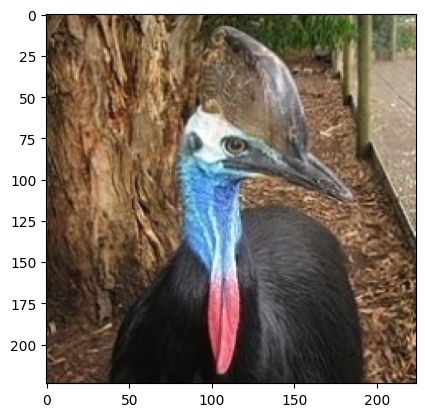

In [5]:
# ploting a sample from my data
def plot_image(generator):
    images_in_batch = next(generator) # images_in_batch will output (batch_size, height, width, n_channels)
    img = images_in_batch[0][0] # img will output (height, width, n_chennels)
    
    plt.imshow(img)

plot_image(train_generator)

In [6]:
# i will be using it to determine steps_per_epoch in my models.
train_groups = len(train_generator) 
valid_groups = len(valid_generator) # validation_step

print(f"Train groups: {train_groups}")
print(f"Validation groups: {valid_groups}")

Train groups: 2641
Validation groups: 82


### MobileNet

In [7]:
# this dense layer i will not only use it for my base model i will use it in the pretrained model too
def dense_layer(inputs, out, dropout_rate = 0.5):
    x = layers.Dense(out)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    
    return x

In [8]:
keras.backend.clear_session()

base_mobilenet = keras.applications.MobileNet(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (224, 224, 3)
)
base_mobilenet.trainable = False

inputs = keras.Input(shape = (224, 224, 3))

x = base_mobilenet(inputs)

x = layers.Flatten()(x)

x = dense_layer(x, 512)

outputs = layers.Dense(category_count, activation = "softmax")(x)
mobilenet_model = keras.Model(inputs, outputs)

2024-01-09 13:34:17.203806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5


In [9]:
mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.01),
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"]
)
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
    
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    
    keras.callbacks.ModelCheckpoint( filepath = "mobilenet_model.keras",save_best_only = True,monitor = "val_loss")
]
history = mobilenet_model.fit( 
    train_generator, 
    steps_per_epoch = train_groups, 
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20


2024-01-09 13:34:22.278461: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-09 13:34:25.036098: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f46e1045890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 13:34:25.036165: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-09 13:34:25.055255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704807265.276439   46237 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2641/2641 [==============================] - 307s 113ms/step - loss: 1.8955 - accuracy: 0.5758 - val_loss: 0.4343 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 2/20
2641/2641 [==============================] - 273s 103ms/step - loss: 0.6177 - accuracy: 0.8335 - val_loss: 0.3752 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 3/20
2641/2641 [==============================] - 257s 97ms/step - loss: 0.3732 - accuracy: 0.8920 - val_loss: 0.3436 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 4/20
2641/2641 [==============================] - 201s 76ms/step - loss: 0.2688 - accuracy: 0.9180 - val_loss: 0.3475 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 5/20
2641/2641 [==============================] - 173s 66ms/step - loss: 0.2131 - accuracy: 0.9340 - val_loss: 0.3430 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 6/20
2641/2641 [==============================] - 191s 72ms/step - loss: 0.1810 - accuracy: 0.9426 - val_loss: 0.3385 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 7/20
2641/2641 [===========================

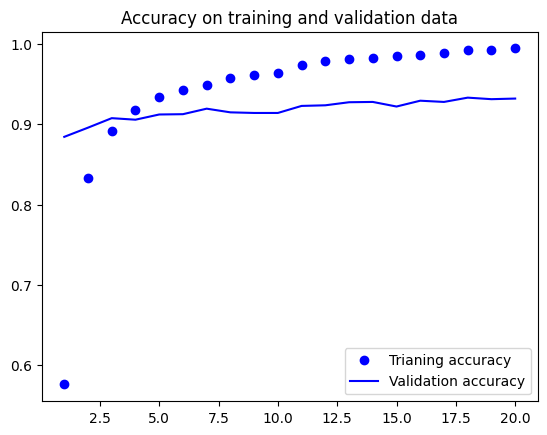

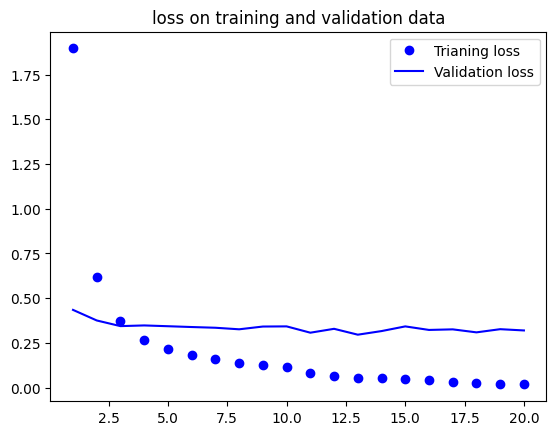

In [10]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

In [11]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(test_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

83/83 [==============================] - 12s 138ms/step - loss: 0.2267 - accuracy: 0.9410
The accuracy of the mobilenet model on the test set is : 0.941


In [17]:
# Get Precision, recall and f1-score
y_true = test_generator.classes
num_samples = len(y_true)
y_pred_probs = test_model_mobile.predict(test_generator, steps=num_samples // 32 + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

83/83 [==============================] - 6s 69ms/step


In [18]:
# Load the MobileNet model from the file
#test_model_mobile = load_model('mobilenet_model.keras')

# Calculate precision, recall, and F1-score
report = classification_report(y_true, y_pred)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      0.57      0.67         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
    

# Making tests to model

In [137]:
testr_directory = 'testr'

In [139]:
testr_generator = general_datagen.flow_from_directory(
    testr_directory,
    target_size = (224, 224),
    batch_size = 1,
    shuffle = False
)

categories = os.listdir(testr_directory) # list the names of the categories that in my data
#print(str(len(categories)),'CATEGORIES are ', categories)

Found 2 images belonging to 2 classes.


In [146]:
# Make predictions on the test et
y_true = testr_generator.classes
num_samples = len(y_true)
y_pred_probs = test_model_mobile.predict(testr_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 0s 32ms/step


In [147]:
print(y_true)
print(y_pred)

[0 1]
[1 2]


In [85]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[0 1 0]
 [0 0 1]
 [0 0 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [14]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(testr_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

2621/2621 [==============================] - 90s 34ms/step - loss: 0.1979 - accuracy: 0.9454
The accuracy of the mobilenet model on the test set is : 0.945


## A test for predicting one bird at a time



In [45]:
from keras.models import load_model

1/1 [==============================] - 1s 602ms/step
[ 10 480 390 511 186 451 452 485 340 344  83 218 137  78 365 240 403 296
 319 212 494 409  27  15 471 151 419 166 147 426 450  43 425 516 277 190
 307 357 294 454 463 404 101 183 438 507 320 453 235 334  62  12 383 348
 108   9 194 248  17 140 193 265 370 380 358 375  64 439  42 314  54 227
   4 169 132  40  52 373 210  74  67 245 431 339  81  92  71 322 482 203
 444  37 449 208 262 251  56 441 302 498 512 443  82 422 400  77 407 399
 228 233 257 309 223 310 395 326 254 214 297 408 123 219   3 446   2 106
 116 243 377 416 338 466 379 372 486 350 518 113 311 172  61 187 306  93
 299 279 150 125 364 492 506 100 135 281 521 270  25 484 475 261 331 104
 355   7 341 401 455 476 278 406 285 398 418 145 182 289  19 134  20 275
 491 447 154 239 329  63 504 167 312 242 385  88 366  90 291 435  41 168
  89 417  95  85 171 505 349 487 423 378 282  69 345 136  76 103 318 272
 238 330 120 177 325  53 432 478 386 457 252 290 234 367 220  75 152 39

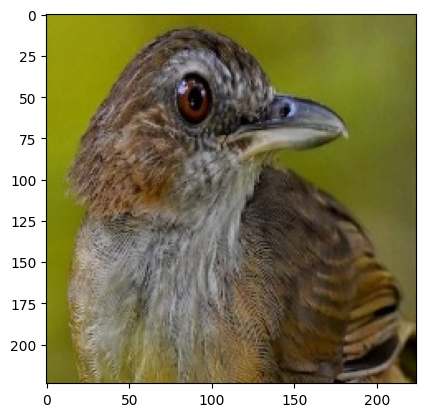

In [61]:
# Load the MobileNet model from the file
mobilenet_model = load_model('mobilenet_model.keras')

plot_image(testr_generator)

test_image = testr_generator[0][0]

# Get predicton from model
prediction = mobilenet_model.predict(test_image)

# Get the predicted class probabilities for all classes
predicted_probabilities = prediction[0]

# Get the predicted class probability
print(np.argsort(predicted_probabilities))
predicted_class_probability = np.argsort(predicted_probabilities)[::-1]


# Select the top three classes with the highest probabilities
top_three_indices = predicted_class_probability[:3]
print(top_three_indices)
# Load the class indices from the "translation_order_of_birds.txt" file
with open('translation_order_of_birds.txt', 'r') as f:
    class_indices_to_labels_json = f.read()
    class_indices_to_labels = json.loads(class_indices_to_labels_json)

# Get the class labels for the top three classes
top_three_labels = [class_indices_to_labels.get(str(i)) for i in top_three_indices]

# Get the corresponding probabilities
top_three_probabilities = [predicted_probabilities[i] for i in top_three_indices]

# Print the predicted label
print(f"Class: {top_three_labels[0]}, Probability: {int(top_three_probabilities[0] * 100)}% \n" 
     + f"Class: {top_three_labels[1]}, Probability: {int(top_three_probabilities[1] * 100)}% \n"
    + f"Class: {top_three_labels[2]}, Probability: {int(top_three_probabilities[2] * 100)}% \n")